In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
#import pickle
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns; sns.set()
import skimage.io as io
import numpy as np
from IPython.display import clear_output
import os, shutil
import numpy as np
from scipy import stats
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import classification_report
#from sklearn.externals import joblib
import joblib
from PIL import Image


%matplotlib inline

In [2]:
dir_data = '../data/AerialImagery/'
JRV_Landsat_Fall_1985Band1 = io.imread(dir_data + 'JRV_Landsat_Fall_1985Band1.tif')

JRV_Landsat_Fall_1990Band1 = io.imread(dir_data + 'JRV_Landsat_Fall_1990Band1.tif')

JRV_Landsat_Fall_1995Band1 = io.imread(dir_data + 'JRV_Landsat_Fall_1995Band1.tif')

JRV_Landsat_Fall_2000Band1 = io.imread(dir_data + 'JRV_Landsat_Fall_2000Band1.tif')

JRV_Landsat_Fall_2005Band1 = io.imread(dir_data + 'JRV_Landsat_Fall_2005Band1.tif')

JRV_Landsat_Fall_2010Band1 = io.imread(dir_data + 'JRV_Landsat_Fall_2010Band1.tif')

JRV_Landsat_Fall_2015Band1 = io.imread(dir_data + 'JRV_Landsat_Fall_2015Band1.tif')

JRV_Landsat_Fall_2017Band1 = io.imread(dir_data + 'JRV_Landsat_Fall_2017Band1.tif')


img = JRV_Landsat_Fall_1985Band1

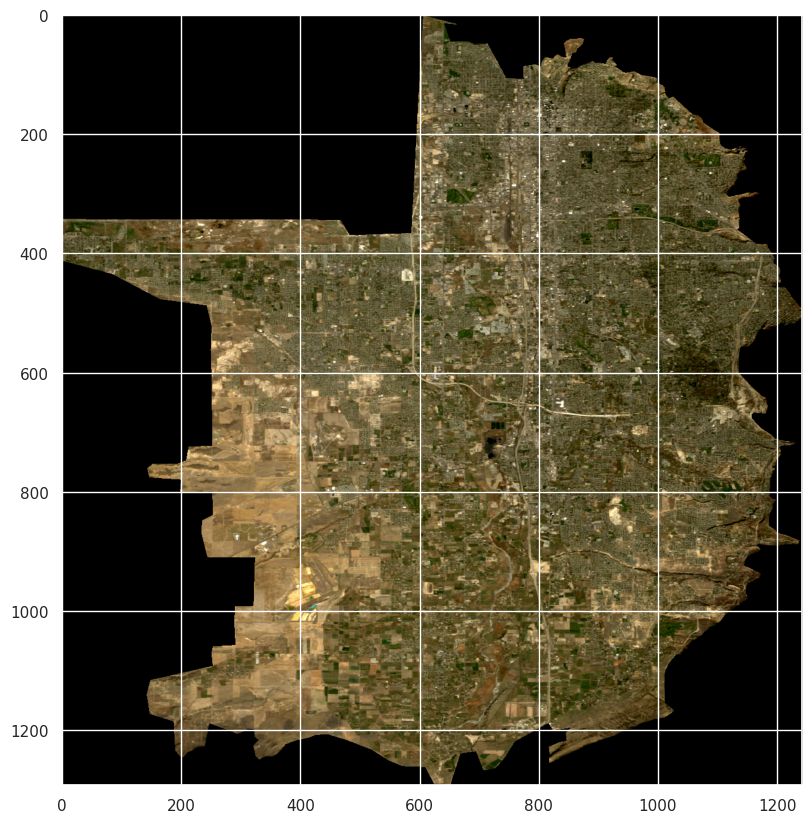

In [3]:
plt.imshow(img)
f = plt.gcf()
f.set_size_inches([10,10])

In [9]:
#Training Dataset for 5 x 5 pixels
#training for Residential vs not, now including the black as not Residential
#the number of training samples you want for both classes
n_samples = 12

#generates a random pixel within the bounds of the image (based on big_sub_image)
rand_pixel = lambda: (np.random.randint(40, img.shape[0]-60), np.random.randint(40,img.shape[1]-60))

#subslice the image
#using a 5x5 pixel square to train model
def sub_image5(p1,p2):
    return img[p1:p1+5,p2:p2+5,:]

#a bigger image for perspective
def big_sub_image(p1,p2):
    return img[p1-40:p1+40,p2-40:p2+40,:]

#a plot of the 2 images for user input
def comparison_plot(tb,t):
    plt.close()
    f, ax = plt.subplots(1,2, figsize =(15,15))
    ax[0].imshow(tb)
    for i in ((40,40),(40,45),(45,40),(45,45)):
        ax[0].scatter(i[0],i[1], marker = '+', color = 'g')
    ax[1].imshow(t)
    plt.show()
   

train_data25 = {}
train_data25['Residential'] = []
train_data25['NotResidential'] = []
while len(train_data25['Residential']) < n_samples or len(train_data25['NotResidential']) < n_samples:
    p = rand_pixel()
    temp = sub_image5(p[0],p[1])
    temp_big = big_sub_image(p[0],p[1])
    comparison_plot(temp_big,temp)

    label = int(input('1 = Residential, 0 = NotResidential, any other number input: pass '))
    if label == 1:
        if len(train_data25['Residential']) < n_samples:
            train_data25['Residential'].append(temp)
    elif label == 0:
        if len(train_data25['NotResidential']) < n_samples:
            train_data25['NotResidential'].append(temp)
    else:
        pass
    clear_output()

In [10]:
#training data25 of p size 25
modelpath = '../output/models/'
joblib.dump(train_data25, modelpath + '1985band1trainRESIDENTIAL_data5.pkl')

['../output/models/1985band1trainRESIDENTIAL_data5.pkl']

In [11]:
#adjust train_data.pkl file to input desired training dataset
train_data = joblib.load(modelpath + '1985band1trainRESIDENTIAL_data5.pkl')
       
#set up train data for running in the model
n_developed=len(train_data['Residential'])
n_undeveloped = len(train_data['NotResidential'])
n_features = len(train_data['Residential'][0].flatten())

X=np.concatenate((   
np.stack(train_data['Residential']).reshape(n_developed, n_features),
np.stack(train_data['NotResidential']).reshape(n_undeveloped, n_features)))

y= np.concatenate((np.ones(n_developed), np.zeros(n_undeveloped)))

#Set up train/test data
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size = 0.33)

In [12]:
def fit_model(Xt,Yt):
    '''
    Fit ML model
    Xt -- training features
    Yt -- training targets
    
    Out
    clf_b -- best model
    '''
    
    #create a Python dictionary of the models you want to try, and hyper-parameters to search over
    models = {}
    # models['Random Forest'] = [RandomForestClassifier(),{'n_estimators':np.arange(100, 400, 50),
    #                                                     'max_depth': np.arange(1,10,1),
    #                                                     'max_features': [0.25,0.33,0.5,0.75,1.],
    #                                                     'random_state': [42],
    #                                                      'n_jobs': [-1]
    #                                                    }]

    models['Random Forest'] = [RandomForestClassifier(),{'n_estimators':np.arange(100,120, 50),
                                                    'max_depth': np.arange(9,10,1),
                                                    'max_features': [0.5],
                                                    'random_state': [42],
                                                        'n_jobs': [-1]
                                                    }]
    
    
    #loop over the models, hyper-paramters and tune through 5-fold cross-validation in the training data
    for i in models.keys():
        clf = GridSearchCV(models[i][0], models[i][1], n_jobs=-1, cv = 5)
        GS = clf.fit(Xt, Yt)
        models[i].append(GS)
        clf_b = models[i][2].best_estimator_
        
    return clf_b

In [13]:
#Set up PCA and RF model
#using a pixel area of 3, pca improves model run and likes components =4 or 5
#adjust ncomp which will work in other aspects below
ncomp = 12
pca = PCA(n_components = ncomp)
X_train = pca.fit_transform(Xtrain)
X_test = pca.transform(Xtest)

#Random forest model
#Use Xtrain for just RF, use X_train for PCA+RF
clf_best = fit_model(X_train, ytrain)
print (clf_best)
ypred = clf_best.predict(X_test)
#1985
#training data is 5x5
#(ncomponents =5), f1-score = 0.73
#(ncomponents =8), f1-score = 0.75
# (ncomponents =10), f1-score = 0.75
# (ncomponents =12), f1-score = 0.81
# (ncomponents =15), f1-score = 0.77
# (ncomponents =17), f1-score = 0.79
# (ncomponents =20), f1-score = 0.77
# (ncomponents =22), f1-score = 0.74
#(ncomponents =25), f1-score = 0.75
#(ncomponents =27), f1-score = 0.79
#(ncomponents =30), f1-score = 0.77


#2000
#training data is 5x5
#(ncomponents =5), f1-score = 0.70
#(ncomponents =8), f1-score = 0.77
# (ncomponents =10), f1-score = 0.79
# (ncomponents =12), f1-score = 0.73
# (ncomponents =15), f1-score = 0.73
# (ncomponents =17), f1-score = 0.77
# (ncomponents =20), f1-score = 0.73
# (ncomponents =22), f1-score = 0.79
#(ncomponents =25), f1-score = 0.81
#(ncomponents =27), f1-score = 0.73
#(ncomponents =30), f1-score = 0.75

#Band1
#1985
#training data is 10x10
# (ncomponents =10), f1-score = 0.6
#(ncomponents =15), f1-score = 0.75
# (ncomponents =20), f1-score = 0.75
# (ncomponents =25), f1-score = 0.75
# (ncomponents =30), f1-score = 0.74
#(ncomponents =33), f1-score = 0.70
# (ncomponents =35), f1-score = 0.
# (ncomponents =40), f1-score = 0.


#2000
#training data is 10x10
#(ncomponents =10), f1-score = 0.53
# (ncomponents =15), f1-score = 0.56
# (ncomponents =20), f1-score = 0.56
# (ncomponents =25), f1-score = 0.55
# (ncomponents =30), f1-score = 0.66
# (ncomponents =33), f1-score = 0.66
# (ncomponents =35), f1-score = 0.56

#2000-2
#training data is 10x10
# (ncomponents =10), f1-score = 0.74
# (ncomponents =15), f1-score = 0.74
#(ncomponents =20), f1-score = 0.72
# (ncomponents =25), f1-score = 0.72
#(ncomponents =30), f1-score = 0.70
# (ncomponents =33), f1-score = 0.74
# (ncomponents =35), f1-score = 0.72

#2000
#training data10 is 15x15
# (ncomponents =10), f1-score = 0.65
# (ncomponents =15), f1-score = 0.65
# (ncomponents =20), f1-score = 0.65
# (ncomponents =25), f1-score = 0.63
#(ncomponents =30), f1-score = 0.68
# (ncomponents =33), f1-score = 0.65
# (ncomponents =35), f1-score = 0.63
#(ncomponents =40), f1-score = 0.67
# (ncomponents =45), f1-score = 0.63
# (ncomponents =50), f1-score = 0.63

#2000
#training data 25x25
# (ncomponents =10), f1-score = 0.79
# (ncomponents =15), f1-score = 0.73
# (ncomponents =20), f1-score = 0.77
# (ncomponents =25), f1-score = 0.75
# (ncomponents =30), f1-score = 0.77
#(ncomponents =35), f1-score = 0.75
#ncomponents =40), f1-score = 0.75
#ncomponents =45), f1-score = 0.75
#ncomponents =55), f1-score = 0.73

#classification report, how well did the model perform?
print(classification_report(ytest, ypred))


RandomForestClassifier(max_depth=np.int64(9), max_features=0.5,
                       n_estimators=np.int64(100), n_jobs=-1, random_state=42)
              precision    recall  f1-score   support

         0.0       0.67      0.33      0.44         6
         1.0       0.20      0.50      0.29         2

    accuracy                           0.38         8
   macro avg       0.43      0.42      0.37         8
weighted avg       0.55      0.38      0.40         8



/home/whitelightning450/mambaforge/envs/ImageClassification_env/lib/python3.9/site-packages/numpy/ma/core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


In [14]:
#Save training data and model as pkl files
#contrary to how i ran the models, train_test# = the number of pixels, the PCA# = number of components
joblib.dump(clf_best, modelpath + '1985Band1train_test_Residential5PCA12.pkl') 

['../output/models/1985Band1train_test_Residential5PCA12.pkl']